# Cardio Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from models.mlp import BlackBoxModel
from models.lr import LogisticRegression
from models.svm import LinearSVM
from models.rbf import RBFNet

pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

c:\Users\leiyo\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read and Process Data

In [2]:
df_ = pd.read_csv('data/cardio/cardio.csv', sep=';')
df = df_.drop(columns=['id'], axis=1).copy()

In [3]:
target_name = 'cardio'
target = df[target_name].replace({})

In [4]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Model Training

In [5]:
features = [
    'age', 
    'gender', 
    'height', 
    'weight', 
    'ap_hi', 
    'ap_lo', 
    'cholesterol',
    'gluc', 
    'smoke', 
    'alco', 
    'active'
]

df_X = df[features].copy()
df_y = df[target_name].copy()

In [6]:
seed = 42

np.random.seed(seed)  # for reproducibility


# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=seed)

std = X_train.std()
mean = X_train.mean()

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

# Initialize the model, loss function, and optimizer
# model = LinearSVM(input_dim=X_train.shape[1])
# model = LogisticRegression(input_dim=X_train.shape[1])
model = BlackBoxModel(input_dim=X_train.shape[1])
# model = RBFNet(input_dim=X_train.shape[1], hidden_dim=X_train.shape[1], output_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

    # Convert outputs to binary using 0.5 as threshold
    y_pred_tensor = (test_outputs > 0.5).float()
    correct_predictions = (y_pred_tensor == y_test_tensor).float().sum()
    accuracy = correct_predictions / y_test_tensor.shape[0]

accuracy.item()

0.7394285798072815

## Counterfactual Explanation

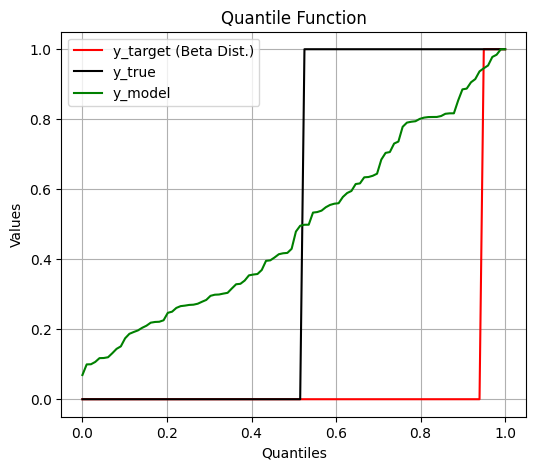

In [45]:
sample_num = 100
delta=0.15
alpha=0.1
N=10
explain_columns = [
    'age', 
    'gender', 
    'height', 
    'weight', 
    'ap_hi', 
    'ap_lo', 
    'cholesterol',
    'gluc', 
    'smoke', 
    'alco', 
    'active'
]

indice = (X_test.sample(sample_num)).index

df_explain = X_test.loc[indice]

# X = X_test.loc[indice].values
y = model(torch.FloatTensor(df_explain.values))

y_target = torch.round(torch.distributions.beta.Beta(0.2, 0.3).sample((sample_num,)))

y_true = y_test.loc[indice]

# Sort the arrays
y_target_sorted = np.sort(y_target.numpy())
y_true_sorted = np.sort(y_true)
y_sorted = np.sort(y.squeeze().detach().numpy())

# Generate quantiles
quantiles = np.linspace(0, 1, sample_num)

# Plotting
plt.figure(figsize=(6, 5))
plt.plot(quantiles, y_target_sorted, label='y_target (Beta Dist.)', color='red')
plt.plot(quantiles, y_true_sorted, label='y_true', color='black')
plt.plot(quantiles, y_sorted, label='y_model', color='green')


plt.title('Quantile Function')
plt.xlabel('Quantiles')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from explainers.dce import DistributionalCounterfactualExplainer

explainer = DistributionalCounterfactualExplainer(
    model=model, 
    df_X=df_explain, 
    explain_columns=explain_columns,
    y_target=y_target, 
    lr=1e-1, 
    n_proj=10,
    delta=delta)

DEBUG:root:test


In [10]:
np.sqrt(explainer.wd.distance(y, y_target, delta=delta)[0].item())

0.39308850717903476

In [11]:
explainer.wd.distance_interval(y, y_target, delta=delta, alpha=alpha, bootstrap=True)

(0.3386157342386583, 0.4142553725973359)

In [12]:
X_s = explainer.X[:, explainer.explain_indices].clone() 
X_t = explainer.X_prime[:, explainer.explain_indices].clone()

In [13]:
np.sqrt(explainer.swd.distance(X_s, X_t, delta)[0].item())

0.010566252137266018

In [14]:
explainer.swd.distance_interval(X_s, X_t, delta=delta, alpha=alpha, bootstrap=False)

(0.0, 0.0)

In [16]:
0.8*(1-0.04)**150

0.0017529718535155077

In [15]:
explainer.optimize(U_1=0.1, U_2=0.25, l=0, r=1, max_iter=100, tau=1e1, kappa=0.02, bootstrap=True)

INFO:root:Optimization started
INFO:root:U_1-Qu_upper=0.1, U_2-Qv_upper=-0.17147529617020624
INFO:root:eta=1, l=0.02, r=1
INFO:root:Iter 1: Q = 0.09514855593442917, term1 = 8.244384662248194e-05, term2 = 0.09514855593442917
INFO:root:U_1-Qu_upper=0.1, U_2-Qv_upper=-0.13739592789918664
INFO:root:eta=1, l=0.039599999999999996, r=1
INFO:root:Iter 2: Q = 0.08718208968639374, term1 = 8.630075899418443e-05, term2 = 0.08718208968639374
INFO:root:U_1-Qu_upper=0.1, U_2-Qv_upper=-0.11993445714400658
INFO:root:eta=1, l=0.058808, r=1
INFO:root:Iter 3: Q = 0.08188818395137787, term1 = 9.190035780193284e-05, term2 = 0.08188818395137787
INFO:root:U_1-Qu_upper=0.1, U_2-Qv_upper=-0.10989315913067593
INFO:root:eta=1, l=0.07763184000000001, r=1
INFO:root:Iter 4: Q = 0.07786848396062851, term1 = 9.802696149563417e-05, term2 = 0.07786848396062851
INFO:root:U_1-Qu_upper=0.1, U_2-Qv_upper=-0.09797241000891549
INFO:root:eta=1, l=0.0960792032, r=1
INFO:root:Iter 5: Q = 0.07434108108282089, term1 = 0.0001032039

In [296]:
# import os 
# import pickle 
# dump_data_path = './data/cardio/'
# with open(os.path.join(dump_data_path, "explainer_convergence.pkl"), "wb") as file:
#     pickle.dump(explainer, file)

In [1]:
# import os 
# import pickle 
# dump_data_path = './data/cardio/'
# with open(os.path.join(dump_data_path, "explainer_convergence.pkl"), 'rb') as file:
#     explainer = pickle.load(file)

c:\Users\leiyo\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
DEBUG:root:test


In [289]:
s_qu = ""
s_u1 = ""

points_qu = list(map(lambda x: x.item(), explainer.swd_upper_list))
# points_list = list(map(lambda x: x.item(), explainer.swd_upper_list))[:iteration]
# points_list = list(map(lambda x: x.item() if type(x)==torch.Tensor else x, explainer.eta_list))
# points_list = explainer.interval_right_list

for i, v in enumerate(points_qu):
    s_qu += f"({i},{v})"
    s_u1 += f"({i},0.1)"
print("Qu, U1")
print(s_qu)
print(s_u1)

Qu, U1
(0,0.0)(1,0.002507180183645169)(2,0.004582773547884998)(3,0.00666269996337544)(4,0.008544549492828143)(5,0.009608986205392826)(6,0.012010725839140087)(7,0.013233650218991812)(8,0.014269230386125289)(9,0.015108004542078328)(10,0.01634171865948192)(11,0.01751973394252672)(12,0.018765800240157917)(13,0.01888185929897657)(14,0.01914923102998905)(15,0.020653497539405197)(16,0.020757187336173055)(17,0.023262685536609318)(18,0.02401184639720428)(19,0.024856478626105637)(20,0.02545506512026178)(21,0.0249836614213983)(22,0.028502346579374695)(23,0.02964526466666)(24,0.02891514919483407)(25,0.030300860205154875)(26,0.030389551619770517)(27,0.03130413192468787)(28,0.032245468795775716)(29,0.03329316078384396)(30,0.033169466506164494)(31,0.03500534213764512)(32,0.03500377699924387)(33,0.03621156799885914)(34,0.036930434398904026)(35,0.03631450100581708)(36,0.03756714404820389)(37,0.04015712514334322)(38,0.03928967178345561)(39,0.040412063363243024)(40,0.04051155948778555)(41,0.0395290457304

In [294]:
s_qv = ""
s_u2 = ""

points_qv = list(map(lambda x: x.item(), explainer.wd_upper_list))

for i, v in enumerate(points_qv):
    s_qv += f"({i},{v})"
    s_u2 += f"({i},0.25)"
print("Qv, U2")
print(s_qv)
print(s_u2)

Qv, U2
(0,0.44121451348978663)(1,0.4103527297848091)(2,0.39026298484897365)(3,0.37731410664365944)(4,0.3662184600057462)(5,0.35757627201037767)(6,0.3462432225326643)(7,0.34389356736226034)(8,0.33638434355601066)(9,0.3312798277453121)(10,0.3319726925992578)(11,0.3243264278022505)(12,0.3182336526828723)(13,0.3171263450828786)(14,0.3147111861506821)(15,0.3091124605503911)(16,0.3126430458262241)(17,0.29966185798921147)(18,0.3070901615830458)(19,0.30329427625794536)(20,0.2972152319488262)(21,0.3030154172693726)(22,0.29601218268889035)(23,0.2948895281932636)(24,0.29065160962797165)(25,0.2865321754158129)(26,0.29027304924353853)(27,0.2847282293540175)(28,0.29291843236514936)(29,0.2798764920236439)(30,0.28168570393173176)(31,0.2812598345944426)(32,0.28449669129770244)(33,0.2763889604086293)(34,0.2774604091964175)(35,0.27357486442086115)(36,0.2766425284342013)(37,0.27498198925719386)(38,0.2714459083255251)(39,0.2690447559747337)(40,0.2695057421514427)(41,0.26616844690364155)(42,0.26528938633105

In [295]:
s_eta = ""
s_eta_r = ""
s_eta_l = ""
eta_points = list(map(lambda x: x.item() if type(x)==torch.Tensor else x, explainer.eta_list))
eta_r_points = explainer.interval_left_list
eta_l_points = explainer.interval_right_list

for i, v in enumerate(eta_points):
    s_eta += f"({i},{v})"

for i, v in enumerate(eta_r_points):
    s_eta_r += f"({i},{v})"

for i, v in enumerate(eta_l_points):
    s_eta_l += f"({i},{v})"

print("eta, (l,r)")
print(s_eta)
print(s_eta_r)
print(s_eta_l)

eta, (l,r)
(0,1)(1,1)(2,1)(3,1)(4,1)(5,1)(6,1)(7,1)(8,1)(9,1)(10,1)(11,1)(12,1)(13,1)(14,1)(15,1)(16,1)(17,1)(18,1)(19,1)(20,1)(21,1)(22,1)(23,1)(24,1)(25,1)(26,1)(27,1)(28,1)(29,1)(30,1)(31,1)(32,1)(33,1)(34,1)(35,1)(36,1)(37,1)(38,1)(39,1)(40,1)(41,1)(42,1)(43,1)(44,1)(45,1)(46,1)(47,1)(48,1)(49,1)(50,1)(51,1)(52,1)(53,1)(54,1)(55,1)(56,1)(57,1)(58,0.9818113624662363)(59,0.984931941491227)(60,0.952299125915993)(61,0.9725750821201997)(62,0.9717119261826045)(63,0.9863458722819485)(64,0.9929951985927163)(65,0.9561112048390057)(66,0.9738739955657754)(67,0.9642709473924403)(68,0.9562690373991594)(69,0.9377561014643394)(70,0.9590811496192432)(71,0.9505656965703217)(72,0.9751423663607772)(73,0.9558757989472738)(74,0.9547762058316175)(75,0.9548540380263429)(76,0.9646852766490968)(77,0.9581155248020804)(78,0.941491681999911)(79,0.9444878968953596)(80,0.9478234376255973)(81,0.9254347066983102)(82,0.9409383836910425)(83,0.9436075680501791)(84,0.9540184024262337)(85,0.9491597901289957)(86,0.9474

In [41]:
which_X = explainer.best_X

factual_X = df[df_X.columns].loc[indice].copy()
counterfactual_X = pd.DataFrame(
    which_X.detach().numpy() * std[df_X.columns].values + mean[df_X.columns].values,
    columns=df_X.columns,
)

dtype_dict = df.dtypes.apply(lambda x: x.name).to_dict()
for k, v in dtype_dict.items():
    if k in counterfactual_X.columns:
        if v[:3] == "int":
            counterfactual_X[k] = counterfactual_X[k].round().astype(v)
        else:
            counterfactual_X[k] = counterfactual_X[k].astype(v)

factual_y = pd.DataFrame(
    y.detach().numpy(), columns=[target_name], index=factual_X.index
)
counterfactual_y = pd.DataFrame(
    explainer.y.detach().numpy(), columns=[target_name], index=factual_X.index
)

# Recover the type of counterfactual_X
dtype_dict = df.dtypes.apply(lambda x: x.name).to_dict()
for k, v in dtype_dict.items():
    if k in counterfactual_X.columns:
        if v[:3] == "int":
            counterfactual_X[k] = counterfactual_X[k].round().astype(v)
        else:
            counterfactual_X[k] = counterfactual_X[k].astype(v)

counterfactual_X.index = factual_X.index
counterfactual_X[target_name] = counterfactual_y
factual_X[target_name] = factual_y

In [29]:
pd.DataFrame({
    'factual_y': factual_y[target_name].values,
    'counterfactual_y': counterfactual_y[target_name].values,
})

,factual_y,counterfactual_y
0,0.121429,0.120085
1,0.274494,0.241892
2,0.211168,0.186047
3,0.752721,0.758078
4,1.000000,1.000000
...,...,...
95,0.785179,0.804111
96,0.222444,0.206944
97,0.451937,0.435571
98,0.704419,0.717976


In [38]:
import os
import pickle 

dump_data_path = './data/cardio/'

factual_X.to_csv(os.path.join(dump_data_path, "factual.csv"), index=False)
counterfactual_X.to_csv(
    os.path.join(dump_data_path, "counterfactual.csv"), index=False
)
with open(os.path.join(dump_data_path, "explainer.pkl"), "wb") as file:
    pickle.dump(explainer, file)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000284CA6C9FA0>
DEBUG:matplotlib.texmanager:family: serif, font: Times, info: \usepackage{mathptmx}
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: \usepackage{type1ec}
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
DEBUG:matplotlib.dviread:Dvi

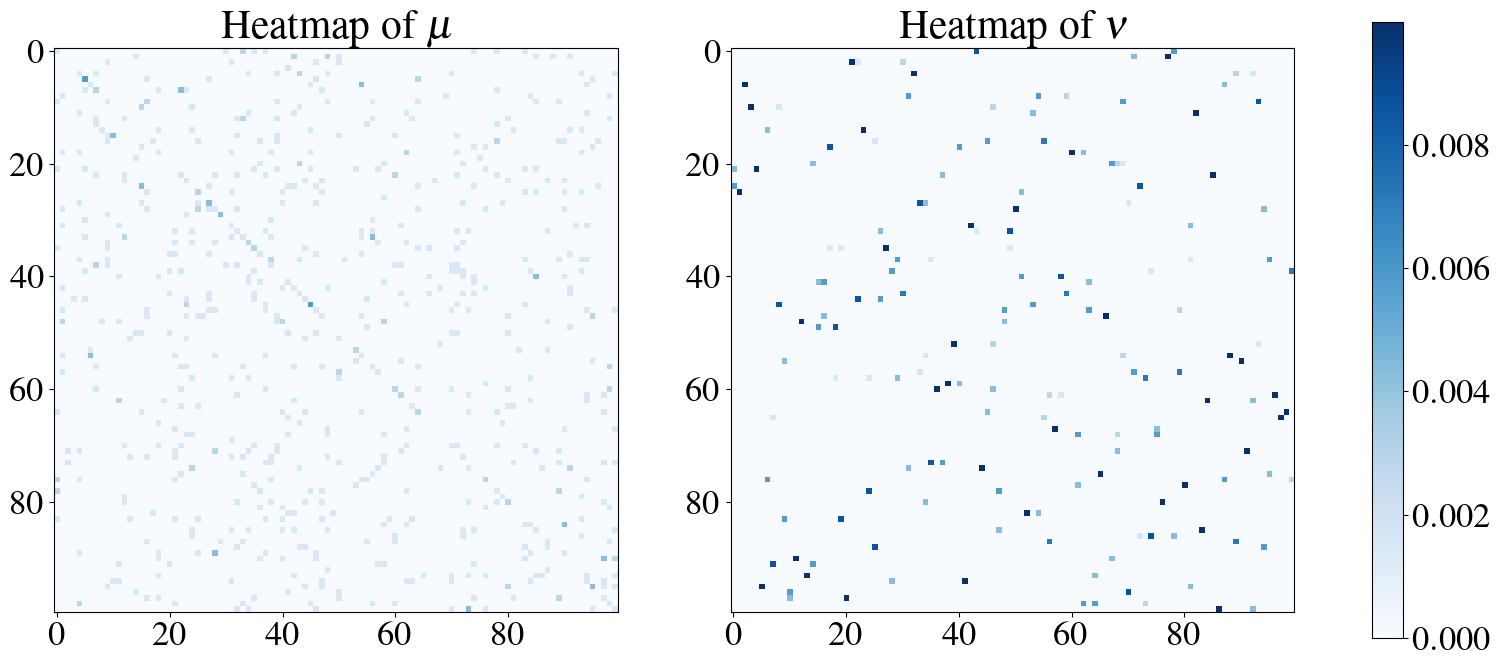

In [10]:
import matplotlib.pyplot as plt

fontsize = 25

# Enable LaTeX text rendering in Matplotlib
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{times}",  # Ensure you use the times package
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman"],  # This should use Times font
    "font.size": fontsize
})

matrix_nu = explainer.wd.nu.detach().numpy()

mu_avg = torch.zeros_like(explainer.swd.mu_list[0])
for mu in explainer.swd.mu_list:
    mu_avg += mu

total_sum = mu_avg.sum()

matrix_mu = mu_avg / total_sum

# Determine the global minimum and maximum values across both matrices
vmin = min(matrix_mu.min(), matrix_nu.min())
vmax = max(matrix_mu.max(), matrix_nu.max())

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8), facecolor='white')  # Set figure background to white

# Set the background of each axis to white
for ax in axs:
    ax.set_facecolor('white')

# First subplot for matrix_mu with 'Blues' color map
im_mu = axs[0].imshow(matrix_mu, cmap='Blues', vmin=vmin, vmax=vmax)
axs[0].set_title("Heatmap of $\mu$")

# Second subplot for matrix_nu with 'Blues' color map
im_nu = axs[1].imshow(matrix_nu, cmap='Blues', vmin=vmin, vmax=vmax)
axs[1].set_title("Heatmap of $\\nu$")

# Create a colorbar for the whole figure
fig.colorbar(im_mu, ax=axs, orientation='vertical')

plt.savefig('pictures/transportation_plan.eps', format='eps', bbox_inches='tight')


# # Display the plots
plt.show()
plt.close(fig)

In [44]:
row_num  = 20

# Interleave rows
combined = pd.concat([factual_X.head(row_num), counterfactual_X.head(row_num)]).sort_index(kind='merge')

# Define formatters for specific columns
formatters = {
    "cardio": lambda x: f"{x:.4f}",
    "weight": lambda x: f"{x:.1f}"
}


# Convert to LaTeX
latex_code = combined.to_latex(index=False, formatters=formatters, 
                               caption="[\\textit{{German-Credit}}] Data points of factual and counterfactual distributions.", label="tab:german-credit")

print(latex_code)

\begin{table}
\caption{[\textit{{German-Credit}}] Data points of factual and counterfactual distributions.}
\label{tab:german-credit}
\begin{tabular}{rrrrrrrrrrrr}
\toprule
age & gender & height & weight & ap_hi & ap_lo & cholesterol & gluc & smoke & alco & active & cardio \\
\midrule
17427 & 2 & 159 & 58.0 & 120 & 80 & 1 & 1 & 0 & 0 & 1 & 0.2225 \\
17438 & 2 & 159 & 57.7 & 114 & 75 & 1 & 1 & 0 & 0 & 1 & 0.1399 \\
20406 & 1 & 162 & 89.0 & 150 & 70 & 1 & 3 & 0 & 0 & 1 & 0.7296 \\
20364 & 1 & 162 & 88.7 & 166 & 80 & 1 & 3 & 0 & 0 & 1 & 0.9224 \\
17733 & 2 & 166 & 70.0 & 150 & 90 & 1 & 1 & 0 & 0 & 0 & 0.9133 \\
17754 & 2 & 166 & 69.9 & 151 & 87 & 1 & 1 & 0 & 0 & 0 & 0.9222 \\
18065 & 2 & 165 & 67.0 & 120 & 80 & 1 & 1 & 0 & 0 & 1 & 0.2618 \\
18059 & 2 & 165 & 67.0 & 107 & 72 & 1 & 1 & 0 & 0 & 1 & 0.1403 \\
21240 & 1 & 162 & 69.0 & 7 & 80 & 1 & 1 & 0 & 0 & 1 & 0.1020 \\
21274 & 1 & 162 & 69.1 & 10 & 77 & 1 & 1 & 0 & 0 & 1 & 0.1035 \\
18169 & 2 & 167 & 70.0 & 100 & 70 & 1 & 1 & 0 & 0 & 1 & 0